# Codon Frequencies
This notebook parses FASTQ files and calculates the frequency of codons at site 734 in Zika Virus NS5 protein.

FASTQ files for each cell population are specified in `samplesheet.csv`

## Notebook setup
Imports

In [1]:
import gzip
import os.path
import numpy as np
import pandas as pd
import plotnine as p9
import regex
from Bio import SeqIO

# print imports and versions
# copied from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' \
                for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.19.1
pandas==1.3.2
plotnine==0.8.0
regex==2.5.83


Input data

In [2]:
samplesheet = 'samplesheet.csv'
reference_file = 'ns5.fasta'
codons_file = 'codons.csv.gz'

Analysis parameters

In [3]:
codon_start = 2203  # nposition in reference for first codon nt
upstream_length = 15  # length of sequence before codon to search for
downstream_length = 15  # length of sequence after codon to search for
mismatches = 1  # number of mismatches allowed (per upstream/downstream sequence)
nucleotides_allowed = 'ACGT'

Notebook aesthetics

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_RICH = ['#648FFF', '#FFB000', '#DC267F', '#785EF0', '#FE6100']

## Load data
Load samples

In [5]:
samples = pd.read_csv(samplesheet)
display(samples)

,sample_name,infected,IFN,read,fastq_file
0,WT_NS5_Sample,True,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
1,Mut_NS5_Sample,True,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
2,Mut_Rnd1_mCherry_neg,True,False,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
3,Mut_Rnd1_mCherry_pos,True,True,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
4,Mut_Rnd2_mCherry_neg,True,False,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
5,Mut_Rnd2_mCherry_pos,True,True,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
6,WT_Plasmid,None,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...
7,Mut_Plasmid,None,None,R1,/shared/ngs/illumina/bloom_lab/210917_M04866_0...


Load reference sequence

In [6]:
reference = SeqIO.read(reference_file, 'fasta')
print(reference.id)
print(reference.seq)

NS5
CGTGGAGGTGGGACGGGAGAGACTCTGGGAGAGAAGTGGAAAGCTCGTCTGAATCAGATGTCGGCCCTGGAGTTCTACTCTTATAAAAAGTCAGGTATCACTGAAGTGTGTAGAGAGGAGGCTCGCCGTGCCCTCAAGGATGGAGTGGCCACAGGAGGACATGCCGTATCCCGGGGAAGTGCAAAGCTCAGATGGTTGGTGGAGAGAGGATATCTGCAGCCCTATGGGAAGGTTGTTGACCTCGGATGTGGCAGAGGGGGCTGGAGCTATTATGCCGCCACCATCCGCAAAGTGCAGGAGGTGAGAGGATACACAAAGGGAGGTCCCGGTCATGAAGAACCCATGCTGGTGCAAAGCTATGGGTGGAACATAGTTCGTCTCAAGAGTGGAGTGGACGTCTTCCACATGGCGGCTGAGCCGTGTGACACTCTGCTGTGTGACATAGGTGAGTCATCATCTAGTCCTGAAGTGGAAGAGACACGAACACTCAGAGTGCTCTCTATGGTGGGGGACTGGCTTGAAAAAAGACCAGGGGCCTTCTGTATAAAGGTGCTGTGCCCATACACCAGCACTATGATGGAAACCATGGAGCGACTGCAACGTAGGCATGGGGGAGGATTAGTCAGAGTGCCATTGTCTCGCAACTCCACACATGAGATGTACTGGGTCTCTGGGGCAAAGAGCAACATCATAAAAAGTGTGTCCACCACAAGTCAGCTCCTCCTGGGACGCATGGATGGCCCCAGGAGGCCAGTGAAATATGAGGAGGATGTGAACCTCGGCTCGGGTACACGAGCTGTGGCAAGCTGTGCTGAGGCTCCTAACATGAAAATCATCGGCAGGCGCATTGAGAGAATCCGCAATGAACATGCAGAAACATGGTTTCTTGATGAAAACCACCCATACAGGACATGGGCCTACCATGGGAGCTACGAAGCCCCCACGCAAGGATCAGCGTCTTCCCTCGTGAACGGGGTTGTTAGACTCCTGTCAAAG

## Parse codon sequence
Parse sequences if codons file is not already given in root directory.

Open codons file if present

In [7]:
if os.path.isfile(codons_file):
    print(f'Loading results from {codons_file}')
    results = pd.read_csv(codons_file)
    print('Done.')
else:
    pass

Loading results from codons.csv.gz


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.


Done.


Extract sequences upstream and downstream of codon

In [8]:
if os.path.isfile(codons_file):
    pass
else:
    # feature positions in reference sequence
    codon_end = codon_start + 2
    upstream_start = codon_start - upstream_length
    upstream_end = codon_start - 1
    downstream_start = codon_end + 1
    downstream_end = codon_end + downstream_length

    # feature values
    # python indexing is not inclusive of first coordinate, so
    # all start positions are adjusted by -1
    codon_reference = reference.seq[(codon_start-1):codon_end]
    upstream = reference.seq[(upstream_start-1):upstream_end]
    downstream = reference.seq[(downstream_start-1):downstream_end]

    # print
    print(f'The codon starts at position {codon_start} and '
          f'ends at position {codon_end} in the reference.')
    print(f'The codon sequence in the reference is: {codon_reference}\n')
    print(f'The upstream search sequence starts at position {upstream_start} '
          f'and ends at position {upstream_end} in the reference.')
    print(f'The upstream search sequence is: {upstream}\n')
    print(f'The downstream search sequence starts at position {downstream_start} '
          f'and ends at position {downstream_end} in the reference.')
    print(f'The downstream search sequence is: {downstream}')

Build regex search

In [9]:
if os.path.isfile(codons_file):
    pass
else:
    pattern = (f'(?:{upstream}){{e<={mismatches}}}' +  # match upstream
                  f'([{nucleotides_allowed}]{{3}})' +  # match and capture codon
                  f'(?:{downstream}){{e<={mismatches}}}')  # match downstream
    print(f'The search pattern for will be:\n{pattern}')

Iterate through reads and store codons:

In [10]:
if os.path.isfile(codons_file):
    pass
else:
    results = list()

    for index, sample in samples.iterrows():
        assert sample['read'] in ['R1', 'R2'], "unrecognized read"
        with gzip.open(sample['fastq_file'], mode='rt') as handle:
            print(f'Parsing data for {sample["sample_name"]} {sample["read"]}')
            print(f'File is:  {sample["fastq_file"]}')
            seqs = SeqIO.parse(handle, 'fastq')
            for sequence in seqs:
                if(sample['read'] == 'R1'):
                    search_seq = sequence.seq
                elif(sample['read'] == 'R2'):
                    search_seq = sequence.seq.reverse_complement()
                result = regex.search(pattern, str(search_seq))
                if result == None:
                    match = None
                    codon = None
                else:
                    match = result.group(0)
                    codon = result.group(1)
                results.append((sample['sample_name'],
                                sample['infected'],
                                sample['IFN'],
                                sequence.id,
                                match,
                                codon))
            print('\n')

    results = pd.DataFrame(results,
                           columns=['sample_name',
                                    'infected',
                                    'IFN',
                                    'read_id',
                                    'match_string',
                                    'codon'])
    print(f'Saving results to {codons_file}')
    results.to_csv(codons_file)

In [11]:
if os.path.isfile(codons_file):
    print(f'Results loaded from {codons_file}')
else:
    print('Results parsed in notebook.')
display(results)

Results loaded from codons.csv.gz


,Unnamed: 0,sample_name,infected,IFN,read_id,match_string,codon,wt
0,0,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:17362:1802,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT,False
1,1,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:18222:1836,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT,False
2,2,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:17286:1855,CCCTTGCCGCCACCAACATGAACTGATTGGCCGA,CAT,False
3,3,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:16342:1902,CCCTTGCCGCCACCAATATGAACTGATTGGCCGA,TAT,False
4,4,WT_NS5_Sample,True,None,M04866:509:000000000-JW58W:1:1101:16389:1914,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT,False
...,...,...,...,...,...,...,...,...
12146275,12146275,Mut_Plasmid,None,None,M04866:509:000000000-JW58W:1:2114:17153:29217,CCCTTGCCGCCACCAATTTGAACTGATTGGCCGA,TTT,False
12146276,12146276,Mut_Plasmid,None,None,M04866:509:000000000-JW58W:1:2114:16532:29221,CCCTTGCCGCCACCAACACGAACTGATTGGCCGA,CAC,False
12146277,12146277,Mut_Plasmid,None,None,M04866:509:000000000-JW58W:1:2114:16271:29222,CCCTTGCCGCCACCAATGTGAACTGATTGGCCGA,TGT,False
12146278,12146278,Mut_Plasmid,None,None,M04866:509:000000000-JW58W:1:2114:17379:29224,CCCTTGCCGCCACCAATGGGAACTGATTGGCCGA,TGG,False


## Plot quality control

Number of reads with codon successfully parsed per sample:

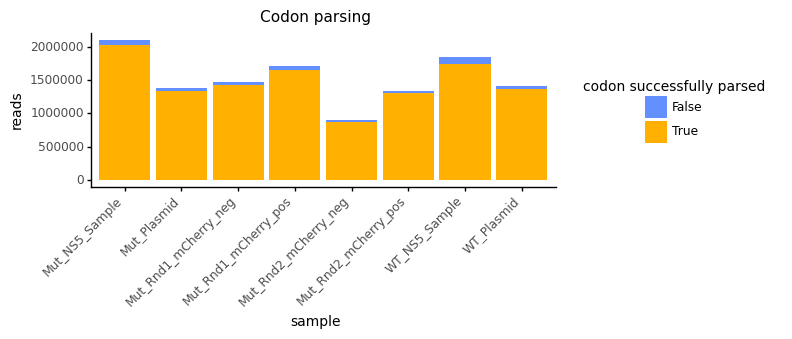

<ggplot: (8770672274414)>

In [12]:
parsing_qc = (p9.ggplot(results) +
              p9.aes(x='sample_name',
                     fill='codon.notnull()') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('Codon parsing') +
              p9.labs(x='sample',
                      y='reads',
                      fill='codon successfully parsed') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(parsing_qc)

## Plot codon frequencies

Label WT codons

In [13]:
results['wt'] = (results['codon'] == 'GAT')

WT vs mutant codons

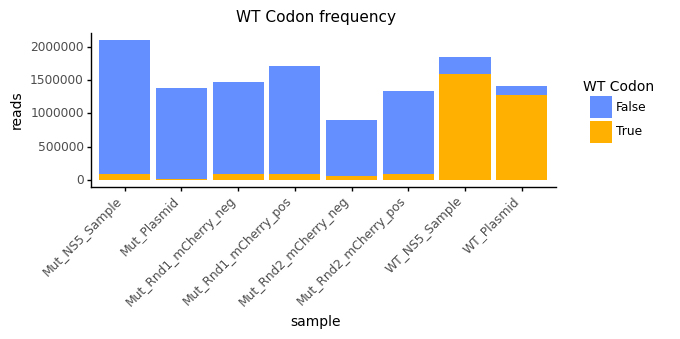

<ggplot: (8770736208637)>

In [14]:
wt_freq = (p9.ggplot(results) +
              p9.aes(x='sample_name',
                     fill='wt') +
              p9.geom_bar(stat='count') +
              p9.ggtitle('WT Codon frequency') +
              p9.labs(x='sample',
                      y='reads',
                      fill='WT Codon') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=11),
                       axis_title=p9.element_text(size=10),
                       axis_text_x=p9.element_text(rotation=45, hjust=1),
                       legend_position='right',
                       legend_title=p9.element_text(size=10),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE_RICH[0:])
              )

display(wt_freq)

Codon counts per sample

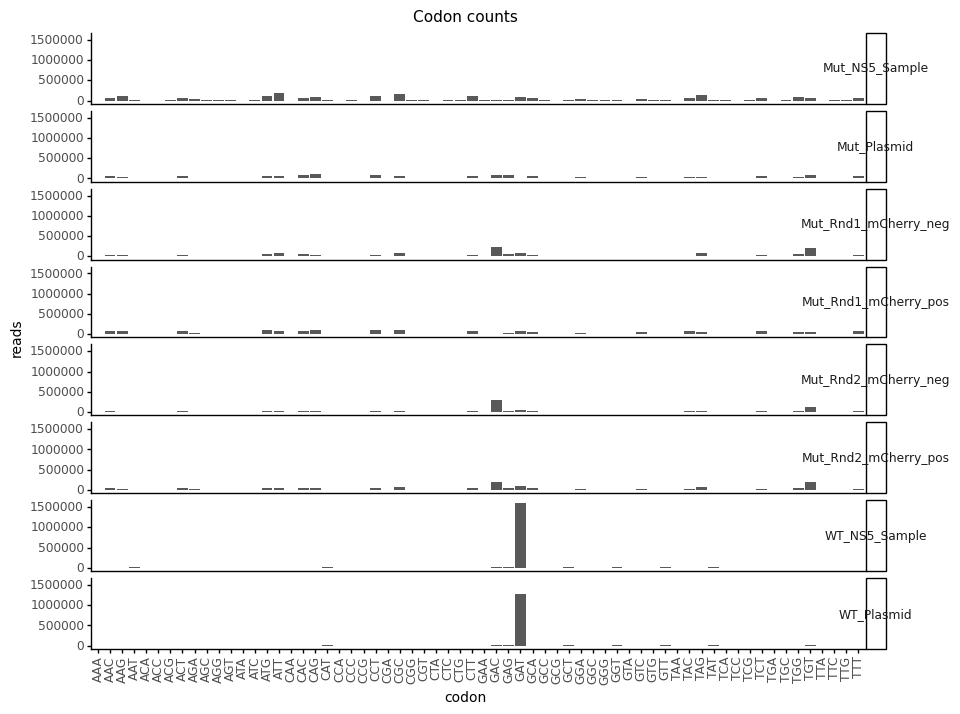

<ggplot: (8770736186085)>

In [15]:
codon_counts = (p9.ggplot(results
                          .query('codon.notnull()',
                                 engine='python')) +
                p9.aes(x='codon',) +
                p9.geom_bar(stat='count') +
                p9.facet_grid('sample_name~') +
                p9.ggtitle('Codon counts') +
                p9.labs(x='codon',
                        y='reads') +
                p9.theme(figure_size=(10, 8),
                         plot_title=p9.element_text(size=11),
                         axis_title=p9.element_text(size=10),
                         axis_text_x=p9.element_text(rotation=90),
                         strip_text_y=p9.element_text(angle = 0))
               )

display(codon_counts)